# Example: Center of Mass calculation

Prerequisites: 

 * a python3.7 to python3.10 virtualenv with all requirements installed
  * LiberTEM 0.5.1 or newer
  * a dataset

In [1]:
%matplotlib inline

In [2]:
import os
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py

from libertem import api

In [3]:
%precision 3

'%.3f'

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [4]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset.

In [5]:
data_base_path = os.environ.get("TESTDATA_BASE_PATH", "/home/alex/Data/")
emd_path = os.path.join(data_base_path, 'scan_11_x256_y256.emd')
hdf5path = 'experimental/science_data/data'

ds = ctx.load(
    'hdf5',
    path=emd_path,
    ds_path=hdf5path,
)

# we could also use the new type="auto" feature:
# here, the ds_path is set automatically to the largest dataset in the HDF5 file
# ds = ctx.load('auth', path=emd_path)

(scan_y, scan_x, detector_y, detector_x) = ds.shape

Now, we create a center of mass (COM) analysis. We set the mask radius to `None` (default) to use the entire frame.

In [6]:
cx = detector_x/2
cy = detector_y/2
analysis = ctx.create_com_analysis(dataset=ds, cx=cx, cy=cy, mask_radius=None)

We kick off the computation:

In [7]:
%time result = ctx.run(analysis, progress=True)

Partitions 0/8, Frames:   0%|          | 0/65536 [00:00<?, ?it/s]

CPU times: user 251 ms, sys: 46.8 ms, total: 298 ms
Wall time: 650 ms


Let's show the result:

In [8]:
print(result)

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: curl>, <AnalysisResult: x>, <AnalysisResult: y>]


In [9]:
print(result.field)

title: field
desc: cubehelix colorwheel visualization
key: field
raw_data: (array([[ 0.279, -0.39 ,  1.15 , ..., -0.689, -0.81 , -1.029],
       [ 0.31 ,  0.555,  0.953, ..., -0.773, -0.907, -1.117],
       [ 0.009,  0.21 ,  0.955, ..., -1.061, -1.306, -1.458],
       ...,
       [ 0.318,  1.007,  0.48 , ...,  0.155,  0.027, -0.295],
       [ 0.637,  0.648, -0.161, ..., -0.055,  0.018, -0.289],
       [ 0.461,  0.487, -0.563, ..., -0.294,  0.233,  0.248]]), array([[-0.809, -0.903, -0.747, ..., -0.871, -0.508, -0.194],
       [-0.582, -0.774, -1.318, ..., -1.524, -0.868, -0.574],
       [-0.69 , -0.929, -0.885, ..., -1.964, -1.477, -0.931],
       ...,
       [-0.334, -0.065, -0.272, ..., -0.582, -0.687, -0.873],
       [-0.09 , -0.894, -1.317, ..., -1.286, -1.189, -1.319],
       [-0.004, -1.227, -0.58 , ..., -0.991, -0.587, -0.602]]))
visualized: [[[144 115 144]
  [128 121 157]
  [165 107 129]
  ...
  [120 124 161]
  [112 129 153]
  [103 135 148]]

 [[142 117 138]
  [150 113 139]
  [1

We show the default visualization for field and for magnitude.

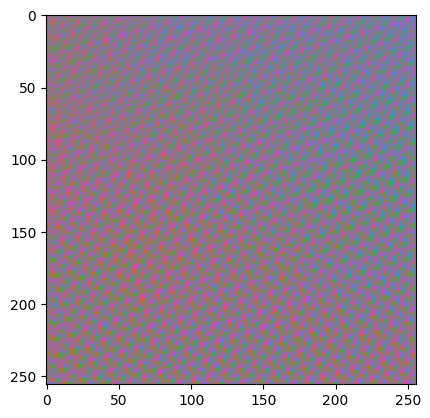

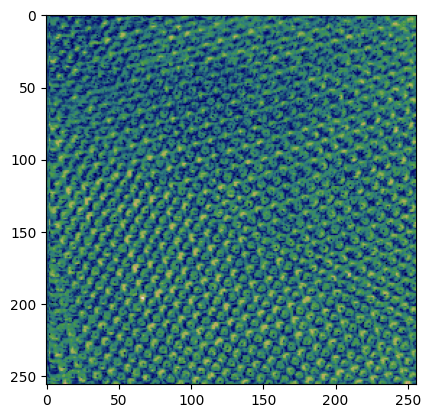

In [10]:
fig, axes = plt.subplots()
axes.imshow(result.field.visualized)
fig, axes = plt.subplots()
axes.imshow(result.magnitude.visualized);

We plot the underlying numerical data for x and y shift

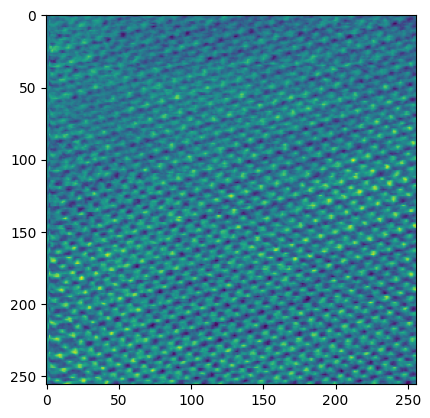

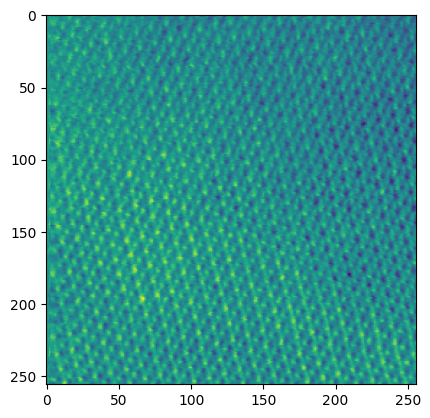

In [11]:
fig, axes = plt.subplots()
axes.imshow(result.y.raw_data)
fig, axes = plt.subplots()
axes.imshow(result.x.raw_data);

We load the upper left frame using picking and compare to the result from the HDF5 file

In [12]:
pick_a = ctx.create_pick_analysis(dataset=ds, y=0, x=0)
pick_res = ctx.run(pick_a)

h5 = h5py.File(emd_path)
raw_res = h5[hdf5path][0, 0]

np.allclose(pick_res.intensity.raw_data, raw_res)

True

We plot the frame

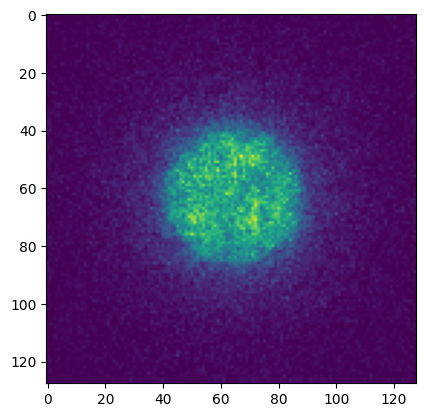

In [13]:
fig, axes = plt.subplots()
axes.imshow(pick_res.intensity.raw_data);

We confirm that the center of mass result matches the scipy result within numerical tolerances.
LiberTEM returns the deviation from the reference center while the function from scipy returns the center in image coordinates. Therefore we add the reference center to the LiberTEM result for comparison.

In [14]:
# NBVAL_IGNORE_OUTPUT
sk_result = measurements.center_of_mass(pick_res.intensity.raw_data)
lt_result = (result.y.raw_data[0, 0] + cy, result.x.raw_data[0, 0] + cx)

print(sk_result)
print(lt_result)

assert np.allclose(
    sk_result,
    lt_result
)

(63.191338347888035, 64.2787578604529)
(63.19135284423828, 64.27876281738281)
